### Export Statements

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ast import literal_eval
import numpy as np
import shap
import time
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures, label_binarize
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve, auc,
    precision_score, recall_score, precision_recall_curve, roc_auc_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
    StackingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.feature_selection import VarianceThreshold

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### Load the dataset

In [3]:
df = pd.read_csv("telesurgery_final_modified_dataset.csv")
df.head()

,Robot Gesture ID,Gesture Type,"Gesture Coordinates (x, y, z)",Timestamp,Gesture Duration (sec),Robot Status,Message ID,Sender,Receiver,Encryption Algorithm Used,Encryption Status,Network Latency (ms),Data Transfer Rate (Mbps),Threat Type,Threat Severity,Response Time (sec),Response Action Taken,Threat Detected
0,10,Incision,"(1.48, 1.4, 0.02)",2025-02-14 16:32:27,5.999538,Idle,22614,Operator,Robot,Two Fish,Encrypted,14.248357,81.723471,Man-in-the-Middle Attack,Low,4.63,Reset Encryption,1
1,8,Diagnosis,"(1.62, 1.81, 0.68)",2025-02-14 16:32:27,2.233173,Idle,61556,Operator,Robot,Two Fish,Encrypted,7.761515,97.531693,DoS Attack,Low,3.94,Reset Encryption,1
2,9,Incision,"(0.67, 1.53, 0.06)",2025-02-14 16:32:27,3.016105,Active,27848,Operator,Robot,Two Fish,Encrypted,12.473764,5.000000,No Threat,Low,0.00,NaN,0
3,1,Incision,"(1.63, 1.74, 1.92)",2025-02-14 16:32:27,0.826854,Idle,60592,Operator,Robot,Two Fish,Encrypted,8.271280,80.073165,Data Breach,High,4.58,Reconnect Connection,1
4,4,Suturing,"(0.53, 0.87, 1.17)",2025-02-14 16:32:27,2.355016,Idle,46712,Robot,Operator,Two Fish,Failed,8.120981,22.173440,Man-in-the-Middle Attack,Low,2.46,Isolate Data,1


In [4]:
print("Summary Statistics:")
print(df.describe())

Summary Statistics:
       Robot Gesture ID  Gesture Duration (sec)    Message ID  \
count       1000.000000             1000.000000   1000.000000   
mean           5.453000                3.416156  54765.611000   
std            2.887582                1.874231  25882.536138   
min            1.000000                0.500000  10047.000000   
25%            3.000000                1.927092  32551.000000   
50%            5.000000                3.343942  54926.500000   
75%            8.000000                4.878103  76859.000000   
max           10.000000                7.213981  99857.000000   

       Network Latency (ms)  Data Transfer Rate (Mbps)  Response Time (sec)  \
count           1000.000000                1000.000000          1000.000000   
mean              12.919279                  51.026504             2.142390   
std                6.194173                  29.274885             1.650706   
min                1.000000                   5.000000             0.000000   

In [5]:
df_encoded = df.copy()
for col in df_encoded.select_dtypes(include=['object']).columns:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

df_encoded.drop(columns=['Timestamp'], inplace=True)

print(df_encoded.isnull().sum())

Robot Gesture ID                 0
Gesture Type                     0
Gesture Coordinates (x, y, z)    0
Gesture Duration (sec)           0
Robot Status                     0
Message ID                       0
Sender                           0
Receiver                         0
Encryption Algorithm Used        0
Encryption Status                0
Network Latency (ms)             0
Data Transfer Rate (Mbps)        0
Threat Type                      0
Threat Severity                  0
Response Time (sec)              0
Response Action Taken            0
Threat Detected                  0
dtype: int64


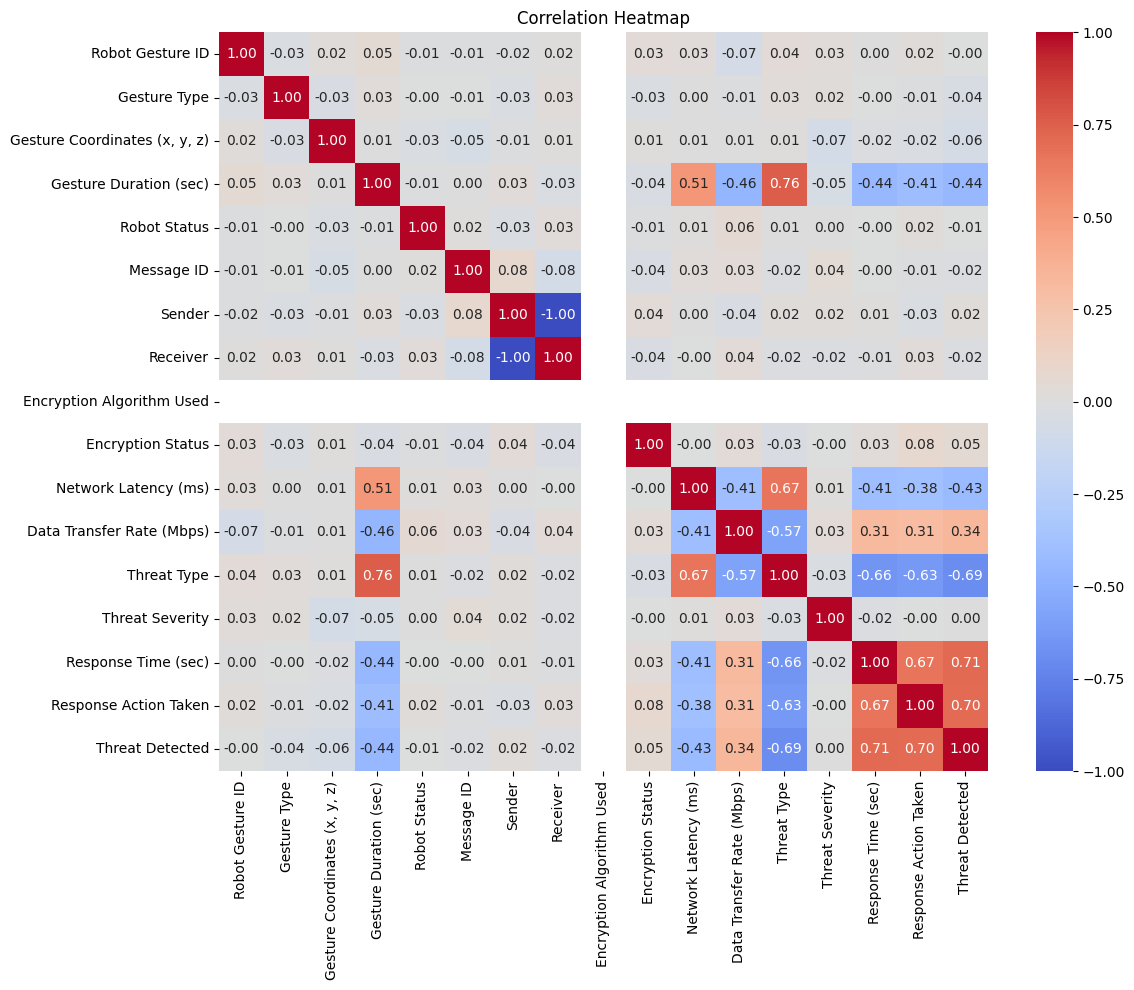

In [6]:
corr = df_encoded.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', 
            mask=np.isnan(corr))
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

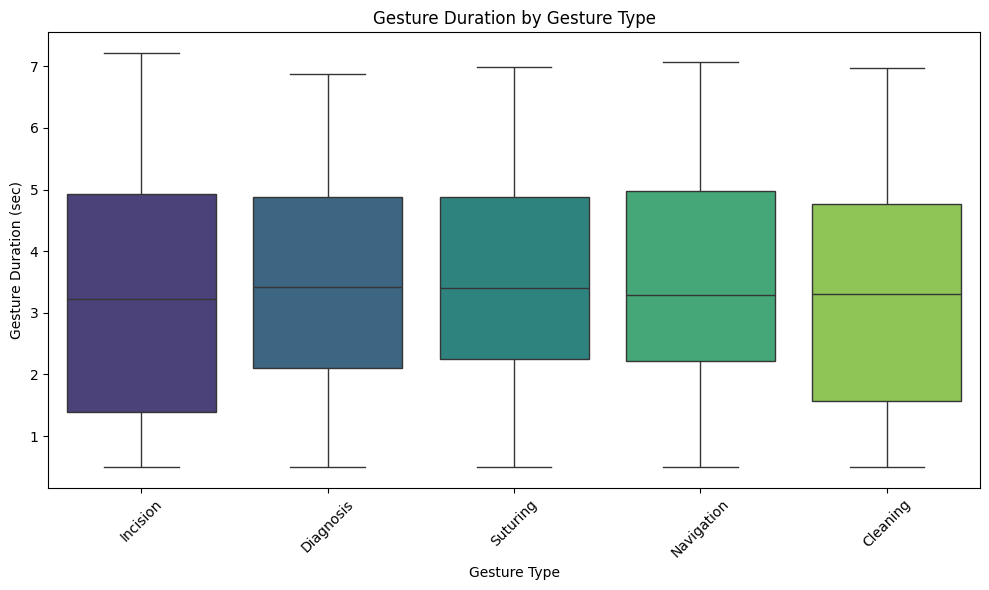

In [7]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Gesture Type', y='Gesture Duration (sec)', hue='Gesture Type', palette='viridis')
plt.title("Gesture Duration by Gesture Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

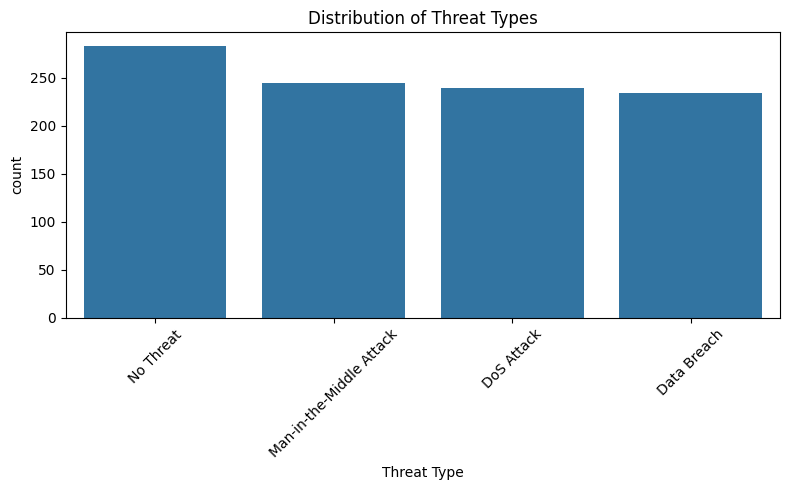

In [8]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Threat Type', order=df['Threat Type'].value_counts().index)
plt.title("Distribution of Threat Types")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

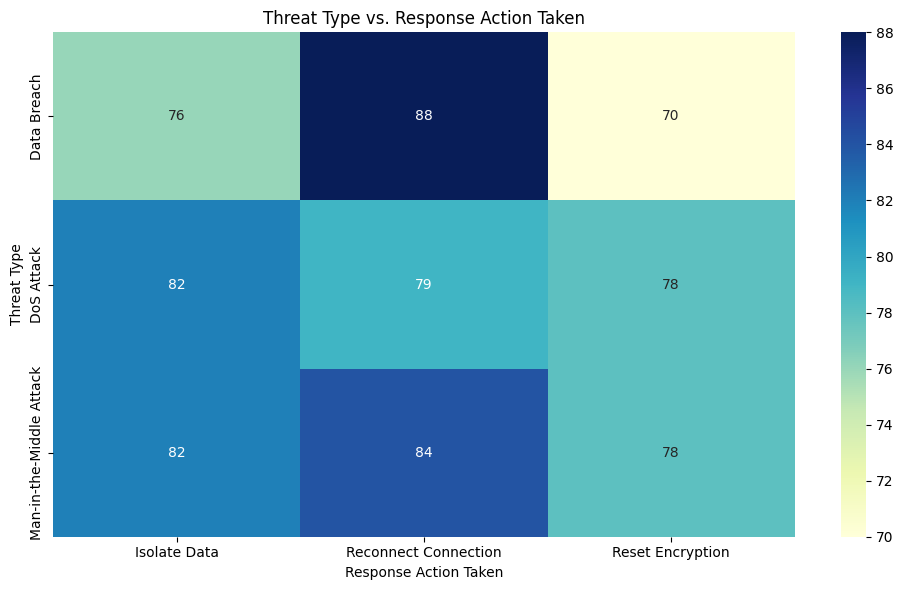

In [9]:
crosstab = pd.crosstab(df['Threat Type'], df['Response Action Taken'])
plt.figure(figsize=(10, 6))
sns.heatmap(crosstab, annot=True, cmap="YlGnBu", fmt='d')
plt.title("Threat Type vs. Response Action Taken")
plt.tight_layout()
plt.show()

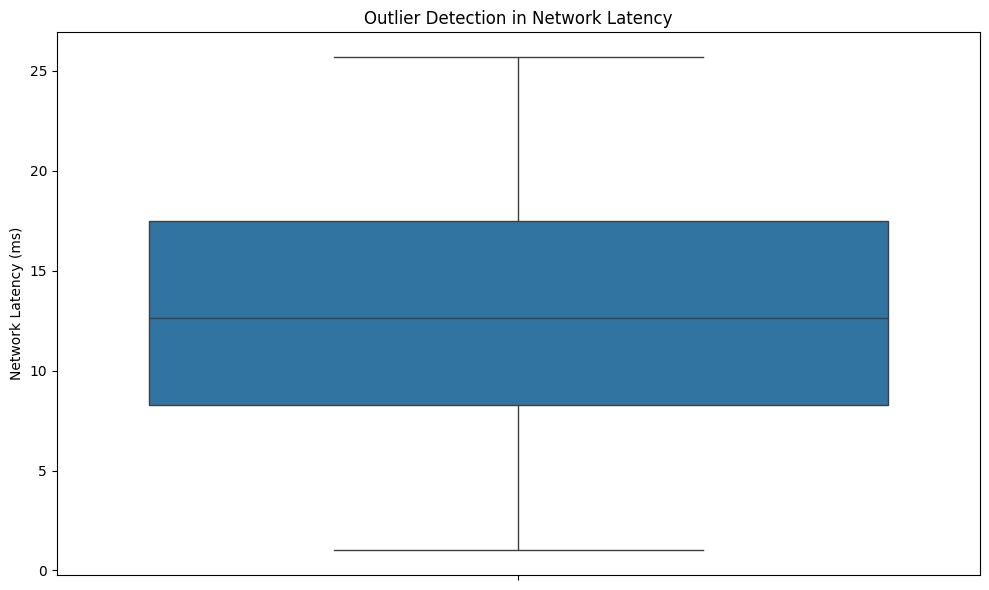

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, y='Network Latency (ms)')
plt.title("Outlier Detection in Network Latency")
plt.tight_layout()
plt.show()

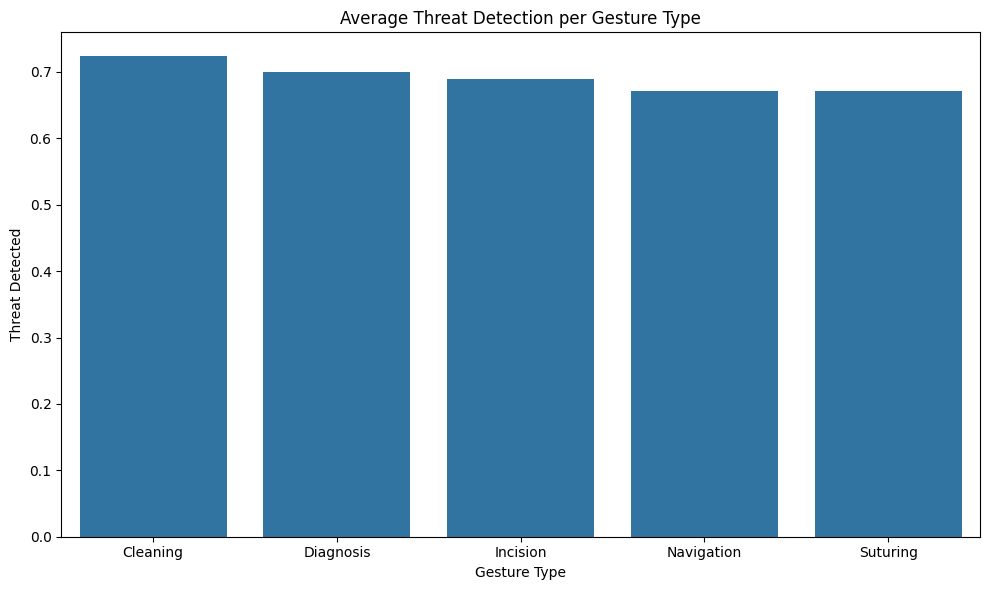

In [11]:
gesture_threat = df.groupby('Gesture Type')['Threat Detected'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=gesture_threat, x='Gesture Type', y='Threat Detected')
plt.title("Average Threat Detection per Gesture Type")
plt.tight_layout()
plt.show()

#### Model training


===== Decision Tree =====


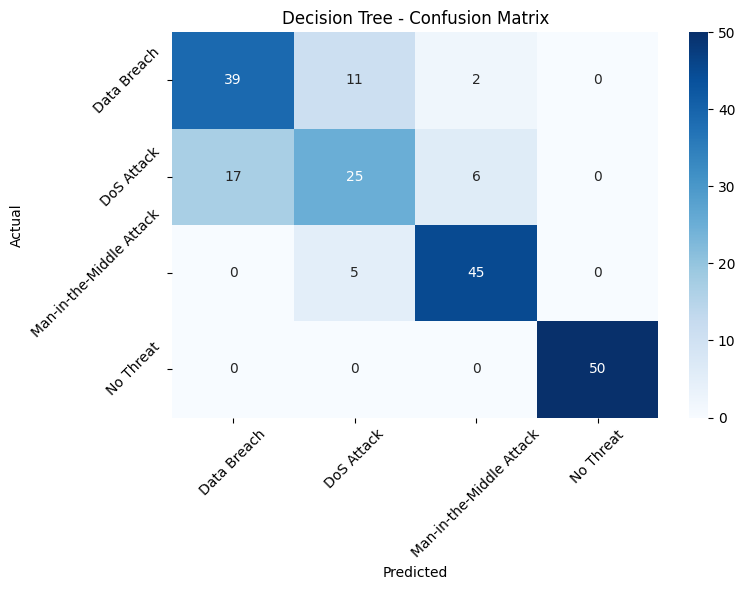

Macro F1 Score: 0.7895

Classification Report:
                          precision    recall  f1-score   support

             Data Breach       0.70      0.75      0.72        52
              DoS Attack       0.61      0.52      0.56        48
Man-in-the-Middle Attack       0.85      0.90      0.87        50
               No Threat       1.00      1.00      1.00        50

                accuracy                           0.80       200
               macro avg       0.79      0.79      0.79       200
            weighted avg       0.79      0.80      0.79       200


===== Random Forest =====


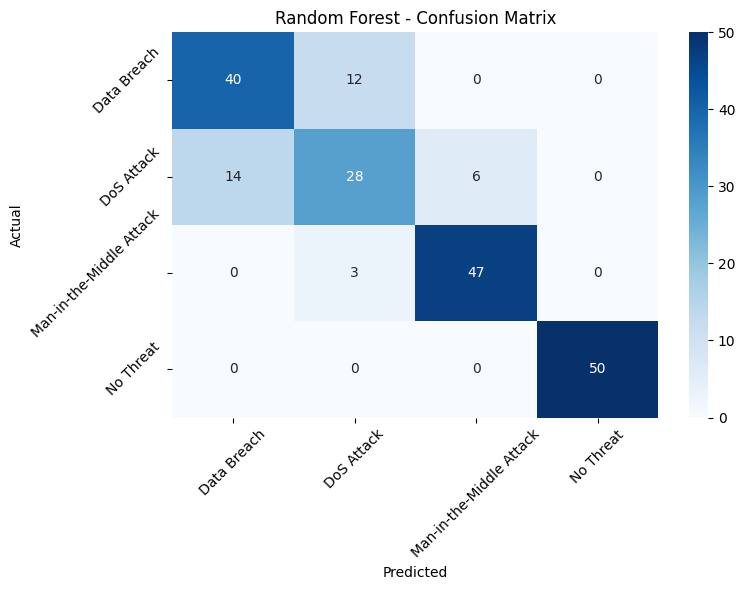

Macro F1 Score: 0.8207

Classification Report:
                          precision    recall  f1-score   support

             Data Breach       0.74      0.77      0.75        52
              DoS Attack       0.65      0.58      0.62        48
Man-in-the-Middle Attack       0.89      0.94      0.91        50
               No Threat       1.00      1.00      1.00        50

                accuracy                           0.82       200
               macro avg       0.82      0.82      0.82       200
            weighted avg       0.82      0.82      0.82       200


===== XGBoost =====


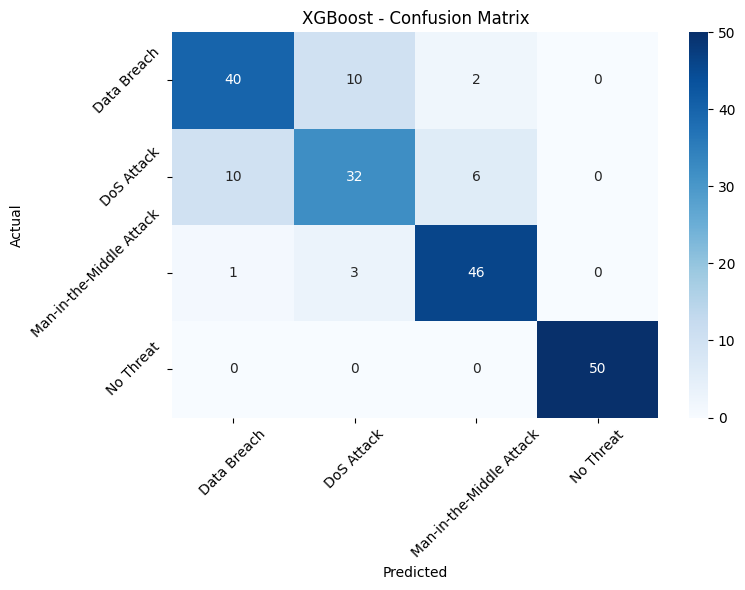

Macro F1 Score: 0.8374

Classification Report:
                          precision    recall  f1-score   support

             Data Breach       0.78      0.77      0.78        52
              DoS Attack       0.71      0.67      0.69        48
Man-in-the-Middle Attack       0.85      0.92      0.88        50
               No Threat       1.00      1.00      1.00        50

                accuracy                           0.84       200
               macro avg       0.84      0.84      0.84       200
            weighted avg       0.84      0.84      0.84       200


===== Stacking Ensemble =====


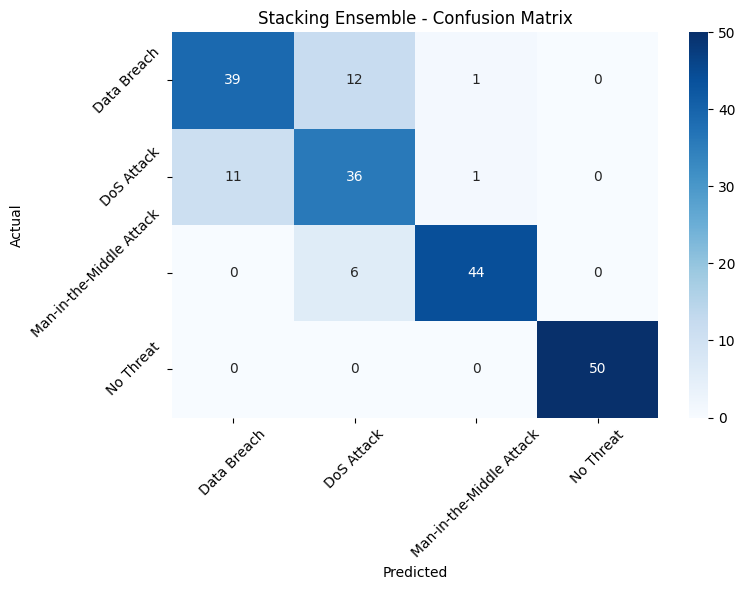

Macro F1 Score: 0.8468

Classification Report:
                          precision    recall  f1-score   support

             Data Breach       0.78      0.75      0.76        52
              DoS Attack       0.67      0.75      0.71        48
Man-in-the-Middle Attack       0.96      0.88      0.92        50
               No Threat       1.00      1.00      1.00        50

                accuracy                           0.84       200
               macro avg       0.85      0.84      0.85       200
            weighted avg       0.85      0.84      0.85       200



In [12]:
df = pd.read_csv("telesurgery_final_modified_dataset.csv")

df.drop(columns=['Gesture Coordinates (x, y, z)', 'Timestamp', 'Encryption Algorithm Used'], inplace=True)

df = df[df['Threat Type'].notna()].copy()

label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

df.dropna(inplace=True)

X = df.drop(columns=['Threat Type'])
y = df['Threat Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

base_scores = []
decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(min_samples_split=2, n_estimators=300, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
svm = SVC(probability=True, random_state=42)
lr = LogisticRegression(max_iter=1000, random_state=42)
stacking = StackingClassifier(
    estimators=[
        ('rf', random_forest),
        ('xgb', xgb),
        ('svm', svm),
        ('lr', lr)
    ],
    final_estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    cv=3,
    n_jobs=-1
)

models = {
    'Decision Tree': decision_tree,
    'Random Forest': random_forest,
    'XGBoost': xgb,
    'Stacking Ensemble': stacking
}

for name, model in models.items():
    print(f"\n===== {name} =====")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoders['Threat Type'].classes_,
                yticklabels=label_encoders['Threat Type'].classes_)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

    macro_f1 = f1_score(y_test, preds, average='macro')
    base_scores.append((name,macro_f1))
    print(f"Macro F1 Score: {macro_f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, preds, target_names=label_encoders['Threat Type'].classes_))

#### Performance comparision of base models

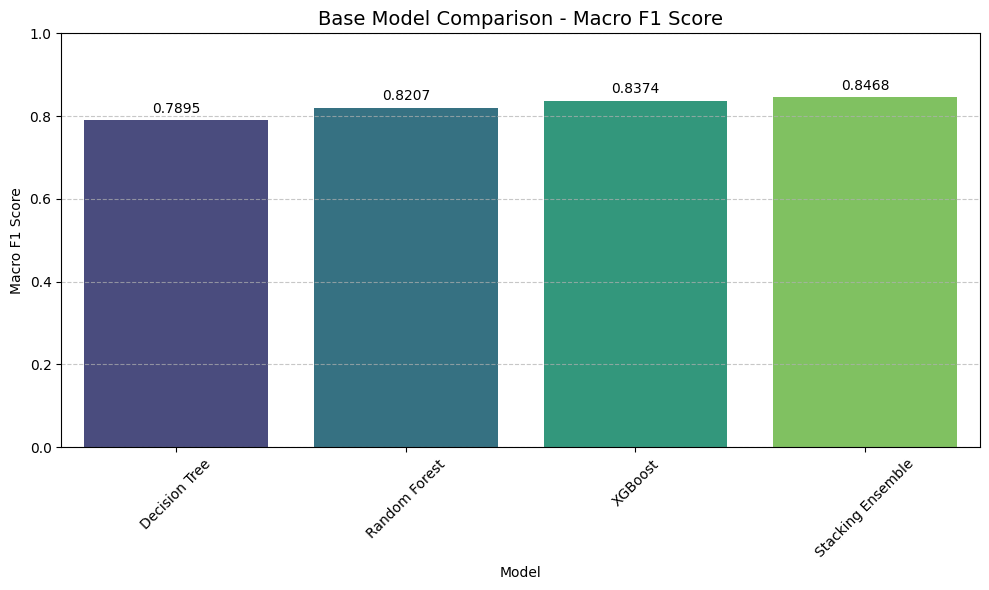

In [13]:
score_df = pd.DataFrame(base_scores, columns=['Model', 'Macro F1 Score'])

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='Macro F1 Score', hue='Model', data=score_df, palette='viridis')

plt.title("Base Model Comparison - Macro F1 Score", fontsize=14)
plt.ylabel("Macro F1 Score")
plt.ylim(0, 1)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.4f}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', xytext=(0, 3), textcoords='offset points')

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Hyper-parameter tuning

#### Fine-tuning Decision Tree


Fitting fine-tuned Decision Tree...
Fitting 5 folds for each of 60 candidates, totalling 300 fits

===== Fine-Tuned Decision Tree =====
Best Parameters:
{'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}


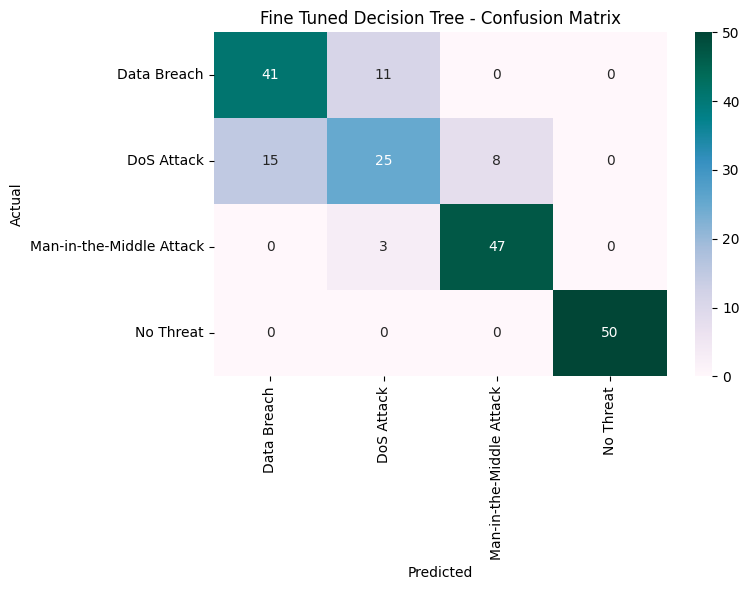

Macro F1 Score: 0.8073

Classification Report:
                          precision    recall  f1-score   support

             Data Breach       0.73      0.79      0.76        52
              DoS Attack       0.64      0.52      0.57        48
Man-in-the-Middle Attack       0.85      0.94      0.90        50
               No Threat       1.00      1.00      1.00        50

                accuracy                           0.81       200
               macro avg       0.81      0.81      0.81       200
            weighted avg       0.81      0.81      0.81       200



In [14]:
results = []

param_grid = {
        'max_depth': [None, 10, 20, 30, 40],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4]
    }

grid_search_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1_macro',
    return_train_score=True,
    cv=5,
    verbose=1,
    n_jobs=-1
)

print("\nFitting fine-tuned Decision Tree...")
grid_search_dt.fit(X_train, y_train)
    
best_dt = grid_search_dt.best_estimator_
best_dt_preds = best_dt.predict(X_test)

print("\n===== Fine-Tuned Decision Tree =====")
print("Best Parameters:")
print(grid_search_dt.best_params_)

cm = confusion_matrix(y_test, best_dt_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='PuBuGn',
            xticklabels=label_encoders['Threat Type'].classes_,
            yticklabels=label_encoders['Threat Type'].classes_)
plt.title("Fine Tuned Decision Tree - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

tuned_macro_f1 = f1_score(y_test, best_dt_preds, average='macro')
results.append(('Decision Tree', tuned_macro_f1))
print(f"Macro F1 Score: {tuned_macro_f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, best_dt_preds, target_names=label_encoders['Threat Type'].classes_))

#### Fine-Tuning Random Forest


Fitting fine-tuned Random Forest...
Fitting 2 folds for each of 8 candidates, totalling 16 fits

===== Fine-Tuned Random Forest =====
Best Parameters:
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


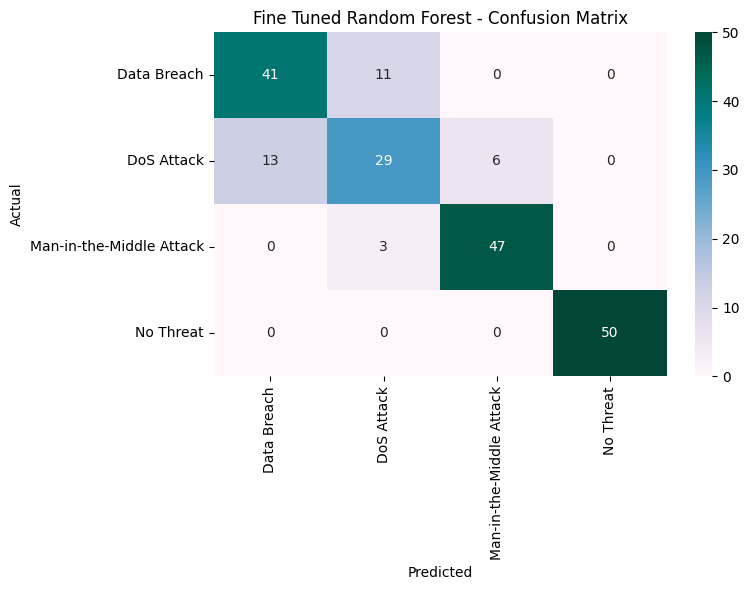

Macro F1 Score: 0.8309

Classification Report:
                          precision    recall  f1-score   support

             Data Breach       0.76      0.79      0.77        52
              DoS Attack       0.67      0.60      0.64        48
Man-in-the-Middle Attack       0.89      0.94      0.91        50
               No Threat       1.00      1.00      1.00        50

                accuracy                           0.83       200
               macro avg       0.83      0.83      0.83       200
            weighted avg       0.83      0.83      0.83       200



In [15]:
param_grid = {
        'n_estimators': [100, 300],
        'max_depth': [None, 10],
        'min_samples_split': [2, 5]
    }

grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1_macro',
    return_train_score=True,
    cv=2,
    verbose=1,
    n_jobs=-1
)

print("\nFitting fine-tuned Random Forest...")
grid_search_rf.fit(X_train, y_train)
    
best_rf = grid_search_rf.best_estimator_
best_rf_preds = best_rf.predict(X_test)

print("\n===== Fine-Tuned Random Forest =====")
print("Best Parameters:")
print(grid_search_rf.best_params_)

cm = confusion_matrix(y_test, best_rf_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='PuBuGn',
            xticklabels=label_encoders['Threat Type'].classes_,
            yticklabels=label_encoders['Threat Type'].classes_)
plt.title("Fine Tuned Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

tuned_macro_f1 = f1_score(y_test, best_rf_preds, average='macro')
results.append(('Random Forest', tuned_macro_f1))
print(f"Macro F1 Score: {tuned_macro_f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, best_rf_preds, target_names=label_encoders['Threat Type'].classes_))

#### Fine-Tuning XG Boost


Fitting fine-tuned XGBoost...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

===== Fine-Tuned XGBoost =====
Best Parameters:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


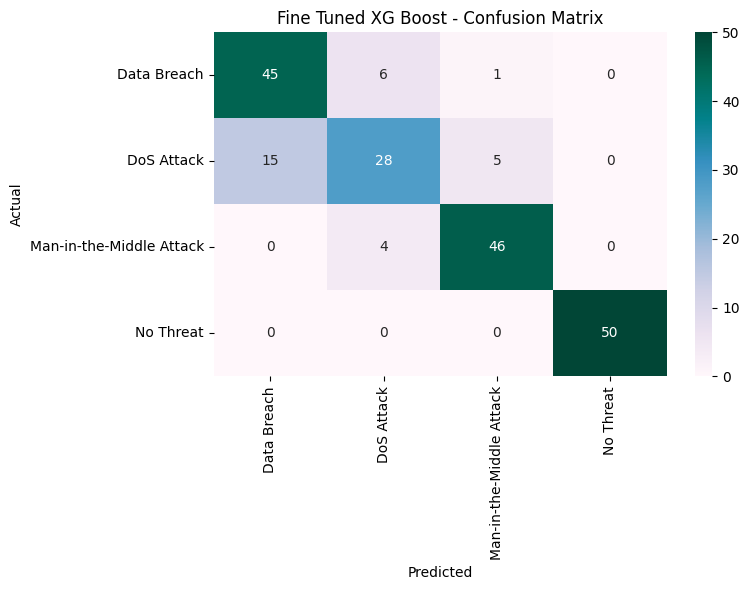

Macro F1 Score: 0.8392

Classification Report:
                          precision    recall  f1-score   support

             Data Breach       0.75      0.87      0.80        52
              DoS Attack       0.74      0.58      0.65        48
Man-in-the-Middle Attack       0.88      0.92      0.90        50
               No Threat       1.00      1.00      1.00        50

                accuracy                           0.84       200
               macro avg       0.84      0.84      0.84       200
            weighted avg       0.84      0.84      0.84       200



In [16]:
param_grid = {
        'n_estimators': [100, 300],
        'max_depth': [3, 6],
        'learning_rate': [0.05, 0.1]
    }

grid_search_xg = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    param_grid=param_grid,
    scoring='f1_macro',
    return_train_score=True,
    cv=3,
    verbose=1,
    n_jobs=-1
)

print("\nFitting fine-tuned XGBoost...")
grid_search_xg.fit(X_train, y_train)
    
best_xg = grid_search_xg.best_estimator_
best_xg_preds = best_xg.predict(X_test)

print("\n===== Fine-Tuned XGBoost =====")
print("Best Parameters:")
print(grid_search_xg.best_params_)

cm = confusion_matrix(y_test, best_xg_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='PuBuGn',
            xticklabels=label_encoders['Threat Type'].classes_,
            yticklabels=label_encoders['Threat Type'].classes_)
plt.title("Fine Tuned XG Boost - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

tuned_macro_f1 = f1_score(y_test, best_xg_preds, average='macro')
results.append(('XG Boost', tuned_macro_f1))
print(f"Macro F1 Score: {tuned_macro_f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, best_xg_preds, target_names=label_encoders['Threat Type'].classes_))

#### Stacking Ensemble using Fine-tuned base models


StackingClassifier using fine tuned base models...


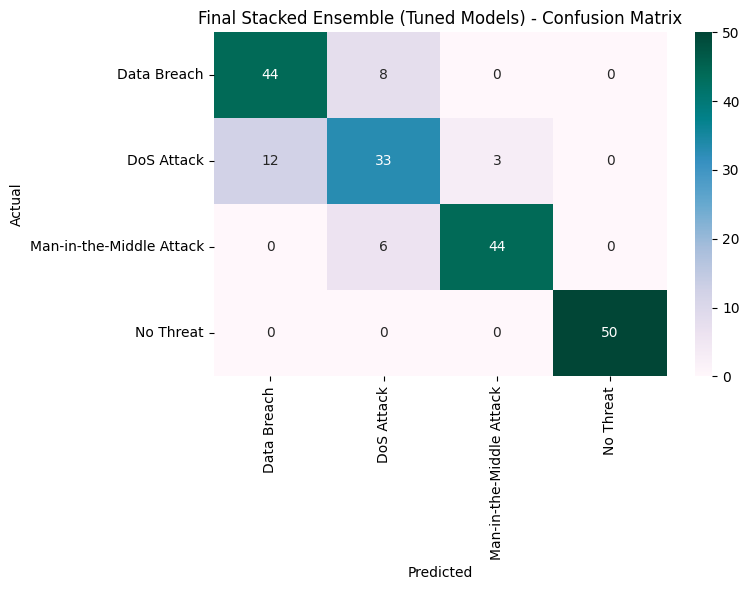

Stacking Macro F1 Score: 0.8542

Classification Report:
                          precision    recall  f1-score   support

             Data Breach       0.79      0.85      0.81        52
              DoS Attack       0.70      0.69      0.69        48
Man-in-the-Middle Attack       0.94      0.88      0.91        50
               No Threat       1.00      1.00      1.00        50

                accuracy                           0.85       200
               macro avg       0.86      0.85      0.85       200
            weighted avg       0.86      0.85      0.86       200



In [17]:
print("\nStackingClassifier using fine tuned base models...")

stacking_final = StackingClassifier(
    estimators=[
        ('rf', best_rf),
        ('xgb', best_xg),
        ('svm', SVC(probability=True, random_state=42)),
        ('lr', LogisticRegression(max_iter=1000, random_state=42)),
    ],
    final_estimator=best_rf,
    cv=2,
    n_jobs=-1
)

stacking_final.fit(X_train, y_train)
stack_preds = stacking_final.predict(X_test)

cm = confusion_matrix(y_test, stack_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='PuBuGn',
            xticklabels=label_encoders['Threat Type'].classes_,
            yticklabels=label_encoders['Threat Type'].classes_)
plt.title("Final Stacked Ensemble (Tuned Models) - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

macro_f1 = f1_score(y_test, stack_preds, average='macro')
results.append(('Stacking Ensemble', macro_f1))
print(f"Stacking Macro F1 Score: {macro_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, stack_preds, target_names=label_encoders['Threat Type'].classes_))

#### Performance Comparision

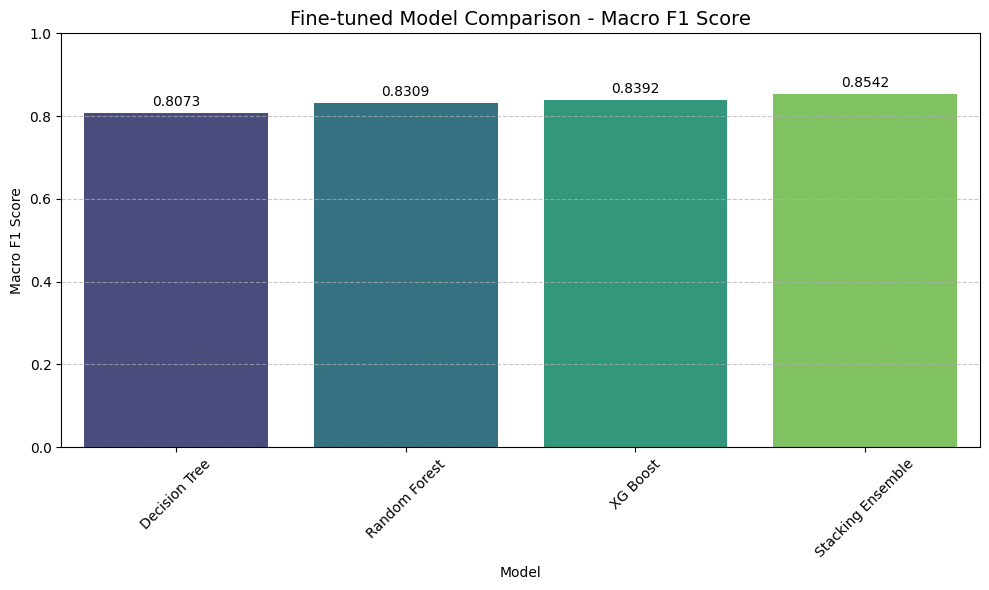

In [18]:
score_df = pd.DataFrame(results, columns=['Model', 'Macro F1 Score'])

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='Macro F1 Score', hue='Model', data=score_df, palette='viridis')

plt.title("Fine-tuned Model Comparison - Macro F1 Score", fontsize=14)
plt.ylabel("Macro F1 Score")
plt.ylim(0, 1)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.4f}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', xytext=(0, 3), textcoords='offset points')

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Shap Analysis

#### Random Forest

Generating SHAP Bar Plot for Random Forest


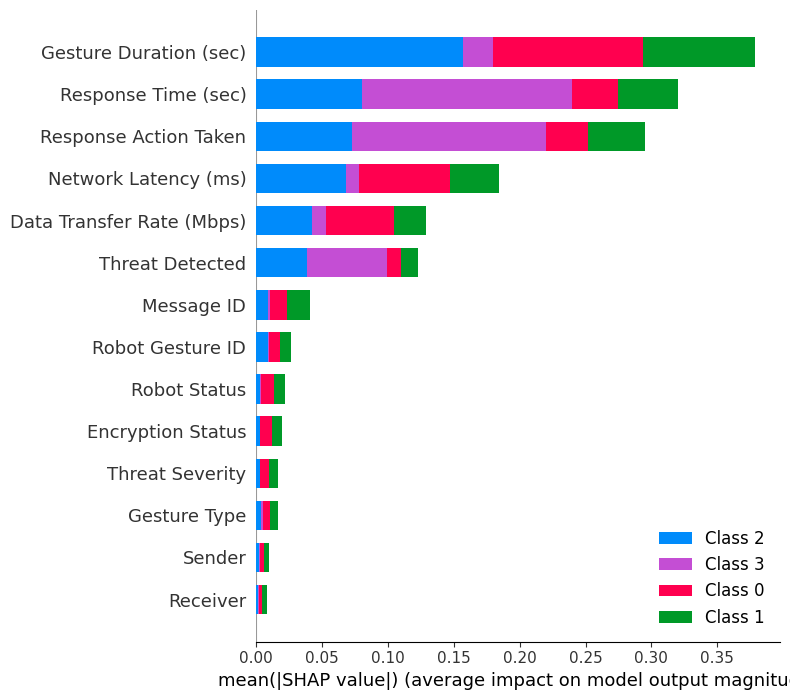

In [19]:
explainer = shap.TreeExplainer(best_rf)

X_sample = X_test.sample(n=100, random_state=42)

shap_values = explainer.shap_values(X_sample)

print("Generating SHAP Bar Plot for Random Forest")
shap.summary_plot(shap_values, X_sample, plot_type="bar", feature_names=X.columns)

#### Decision Tree

Generating SHAP Bar Plot for Decision Tree


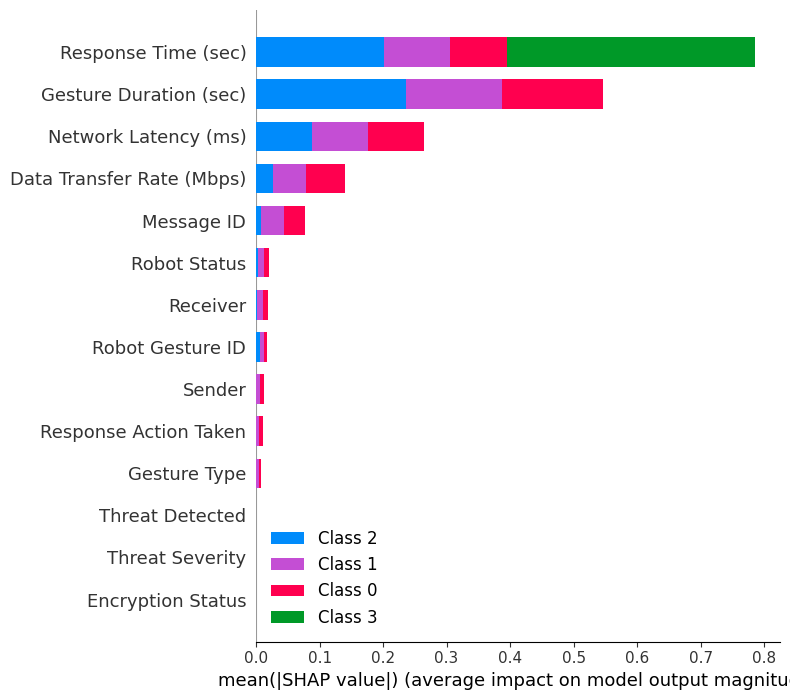

In [20]:
explainer = shap.TreeExplainer(best_dt)

X_sample = X_test.sample(n=100, random_state=42)

shap_values = explainer.shap_values(X_sample)

print("Generating SHAP Bar Plot for Decision Tree")
shap.summary_plot(shap_values, X_sample, plot_type="bar", feature_names=X.columns)

#### XG Boost

Generating SHAP Bar Plot for XG Boost


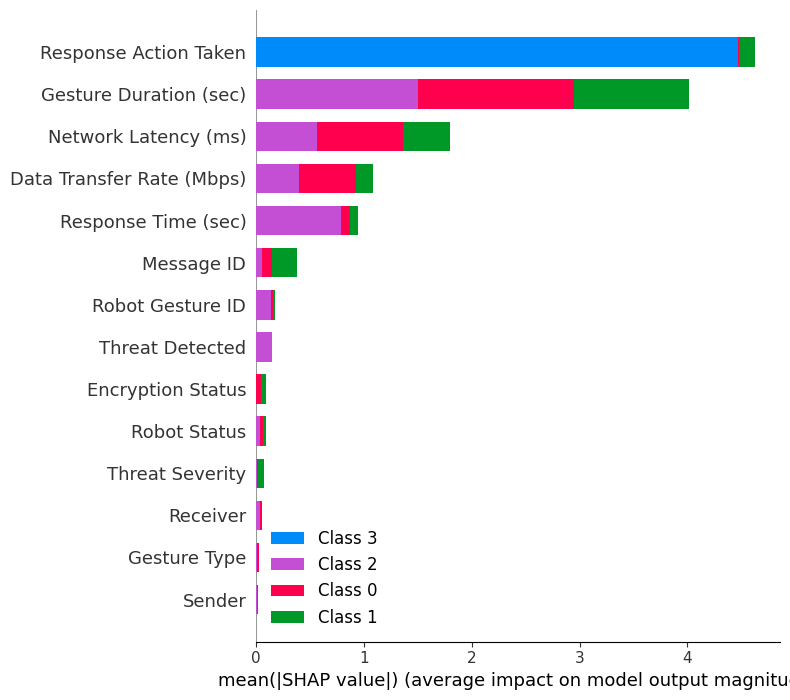

In [21]:
explainer = shap.TreeExplainer(best_xg)

X_sample = X_test.sample(n=100, random_state=42)

shap_values = explainer.shap_values(X_sample)

print("Generating SHAP Bar Plot for XG Boost")
shap.summary_plot(shap_values, X_sample, plot_type="bar", feature_names=X.columns)

### Feature Importance

#### Random Forest


Top Feature Importances for Random Forest:
                      Feature  Importance
2      Gesture Duration (sec)    0.200224
11        Response Time (sec)    0.179755
8        Network Latency (ms)    0.139921
12      Response Action Taken    0.130085
9   Data Transfer Rate (Mbps)    0.110484
13            Threat Detected    0.076585
4                  Message ID    0.056018
0            Robot Gesture ID    0.030614
1                Gesture Type    0.023913
10            Threat Severity    0.015878


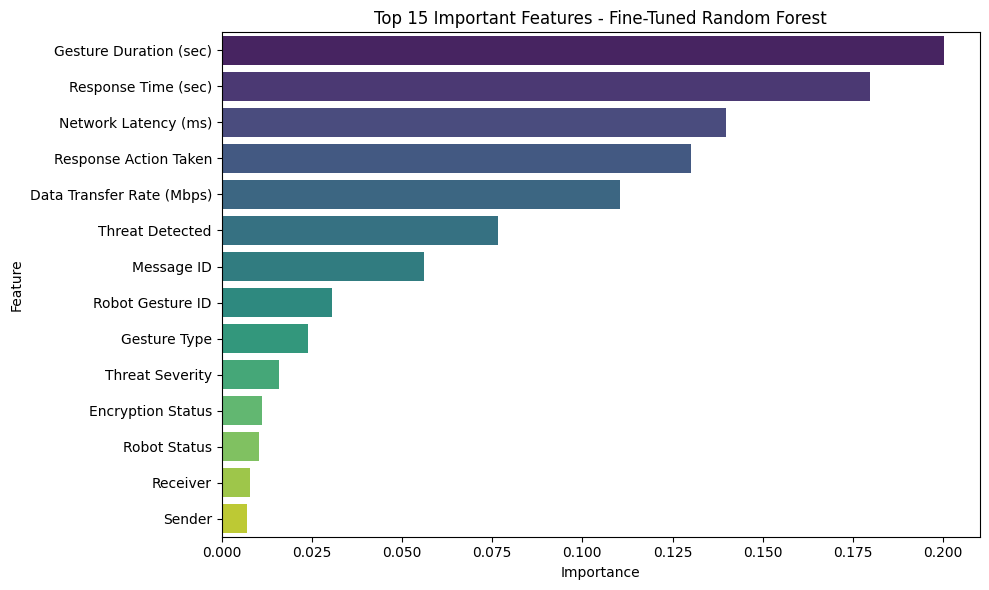

In [22]:
importances = best_rf.feature_importances_
feature_names = X.columns

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nTop Feature Importances for Random Forest:")
print(feat_imp_df.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=feat_imp_df.head(15), palette='viridis', legend=False)
plt.title('Top 15 Important Features - Fine-Tuned Random Forest')
plt.tight_layout()
plt.show()


#### Decision Tree


Top Feature Importances for Decision Tree:
                      Feature  Importance
11        Response Time (sec)    0.405281
2      Gesture Duration (sec)    0.292926
8        Network Latency (ms)    0.147939
9   Data Transfer Rate (Mbps)    0.066119
4                  Message ID    0.044032
0            Robot Gesture ID    0.014039
6                    Receiver    0.008524
3                Robot Status    0.007535
1                Gesture Type    0.005190
12      Response Action Taken    0.005062


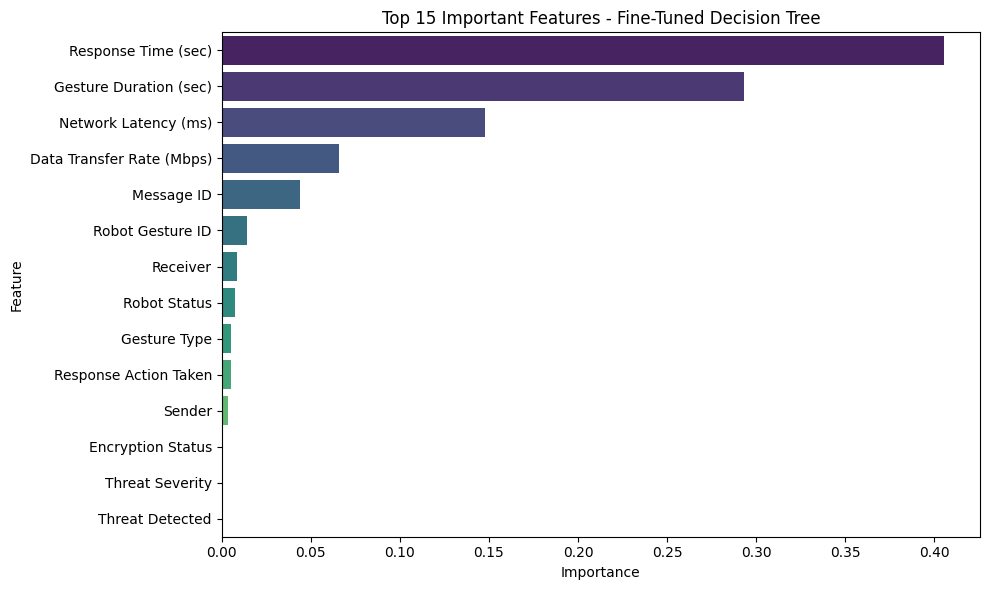

In [23]:
importances = best_dt.feature_importances_
feature_names = X.columns

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nTop Feature Importances for Decision Tree:")
print(feat_imp_df.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=feat_imp_df.head(15), palette='viridis', legend=False)
plt.title('Top 15 Important Features - Fine-Tuned Decision Tree')
plt.tight_layout()
plt.show()


#### XG Boost


Top Feature Importances for XG Boost:
                      Feature  Importance
12      Response Action Taken    0.429935
2      Gesture Duration (sec)    0.159758
11        Response Time (sec)    0.118943
8        Network Latency (ms)    0.063288
13            Threat Detected    0.043183
9   Data Transfer Rate (Mbps)    0.042203
6                    Receiver    0.025331
4                  Message ID    0.021188
10            Threat Severity    0.020861
5                      Sender    0.019321


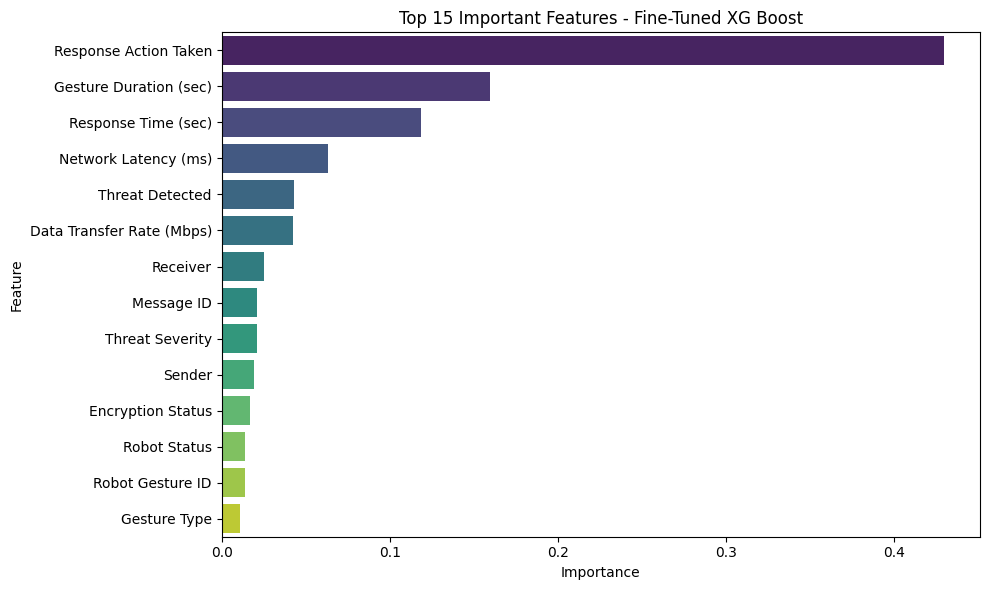

In [24]:
importances = best_xg.feature_importances_
feature_names = X.columns

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nTop Feature Importances for XG Boost:")
print(feat_imp_df.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=feat_imp_df.head(15), palette='viridis', legend=False)
plt.title('Top 15 Important Features - Fine-Tuned XG Boost')
plt.tight_layout()
plt.show()


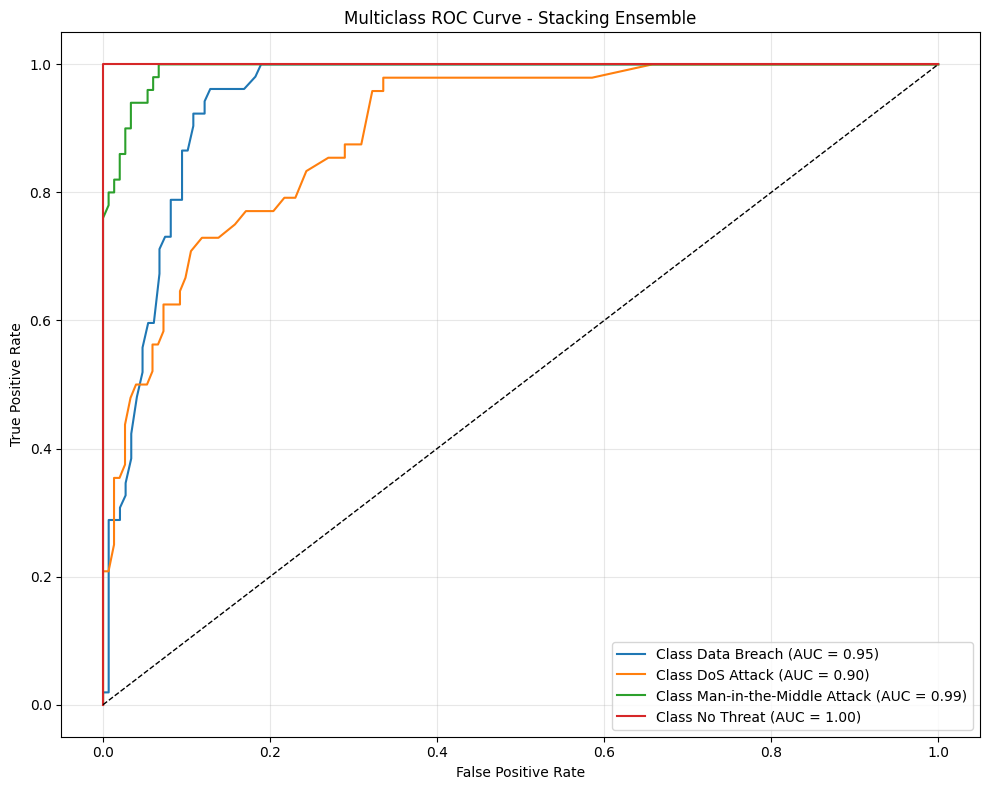

In [25]:
stacking_final.fit(X_train, y_train)

y_score = stacking_final.predict_proba(X_test)

class_labels = np.unique(y)
y_test_bin = label_binarize(y_test, classes=class_labels)
n_classes = y_test_bin.shape[1]

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {label_encoders['Threat Type'].inverse_transform([i])[0]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title('Multiclass ROC Curve - Stacking Ensemble')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()